In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dive-into-graphs
#!pip install pydig

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
from time import perf_counter
import csv
import torch.nn as nn
import torch_geometric.nn as gnn
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from torch.nn.modules import activation
from time import perf_counter
import random
import pandas

#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
#from dig.xgraph.dataset import SynGraphDataset
#from dig.xgraph.method import PGExplainer
#from dig.xgraph.utils.compatibility import compatible_state_dict
#from dig.xgraph.method.subgraphx import PlotUtils
#from dig.xgraph.method.subgraphx import MCTS
#from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'LRP'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [5]:
#dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
#dataset = GINDataset('MUTAG', self_loop=False)


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [6]:
print("Number of Graphs: ", len(dataset))
print("Number of Node Features: ", dataset.num_node_features)
print("Number of Edge Features: ", dataset.num_edge_features)
#print("Number of Node Features: ", dataset.num_node_attributes)
#print("Number of Node Features: ", dataset.num_edge_attributes)
print("Number of Classes: ", dataset.num_classes)
count=0
for i in range(len(dataset)):
  count = count + len(dataset[i].edge_index[0])
print("Number of Edges: ", count)
data = dataset[0]
print(data)
#print(dataset.labels)

Number of Graphs:  188
Number of Node Features:  7
Number of Edge Features:  4
Number of Classes:  2
Number of Edges:  7442
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [7]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
  read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
  read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [8]:
#torch.manual_seed(123456)

#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#train_dataset = dataset[:150]
#test_dataset = dataset[150:]

train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
  train_dataset.append(dataset[index])
for index in read_test_list_indexes:
  test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38
Number of training graphs: 150
Number of test graphs: 38


In [9]:
print("Number of Training Graphs: ", len(train_dataset))
print("Number of Test Graphs: ", len(test_dataset))

count=0
for i in range(len(train_dataset)):
  count = count + len(train_dataset[i].edge_index[0])
print("Number of Edges in TrainingSet: ", count)
count=0
for i in range(len(test_dataset)):
  count = count + len(test_dataset[i].edge_index[0])
print("Number of Edges in TestSet: ", count)

Number of Training Graphs:  150
Number of Test Graphs:  38
Number of Edges in TrainingSet:  6064
Number of Edges in TestSet:  1378


In [10]:
g = train_dataset[0]
print(g.y)

tensor([1])


## **Batching Data by DataLoader**

In [11]:
from torch_geometric.loader import DataLoader
BATCH_SIZE = 64

torch.manual_seed(123456)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
print(train_dataset[0])
#print(train_dataset[0][0])
#print(train_dataset[0][0])
print(train_dataset[0])
######print(GCN_Model(dataset[0].x, dataset[0].edge_index))

Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])
Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])


In [ ]:
print(train_loader.batch_size)
batch = next(iter(train_loader))
print(batch.y)
print(len(train_loader))

64
tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])
3


In [ ]:
for batch in train_loader:
  print(batch.y)

tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1])
tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1])


In [ ]:
feat_size = train_dataset[0].x.shape[1]
print(feat_size)
#DGL_Model = Graph_Model(feat_size, dataset.gclasses)

7


# **GCN MODEL**

In [13]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [14]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [15]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [16]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [17]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            if self._explain:
                edge_mask = self.__edge_mask__
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [18]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden, bias=False)
        #self.elu1 = nn.functional.elu() 
        
        self.gconv2 = GCNConv(dim_hidden, dim_hidden, bias=False)
        #self.elu2 = nn.functional.elu()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output, bias=False)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = nn.functional.elu(self.gconv1(x, edge_index))
        #out_readout1 = self.readout(post_conv1, batch)
        #print(np.shape(out_readout1))
        post_conv2 = nn.functional.elu(self.gconv2(post_conv1, edge_index))
        out_readout = self.readout(post_conv2, batch)

        #print(np.shape(out_readout))
        out = self.ffn(out_readout)

        return post_conv1, post_conv2, out_readout, out

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(post_conv1, edge_index))
            
        return post_conv2

In [19]:
feat_size = train_dataset[0].x.shape[1]
GCN_Model = GCN_2l_Model(model_level='graph', dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

post_conv1, post_conv2, out_readout, out = GCN_Model(dataset[0].x, dataset[0].edge_index, dataset[0].batch)
print(out)

GCN_2l_Model(
  (gconv1): GCNConv(7, 7)
  (gconv2): GCNConv(7, 7)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


AttributeError: ignored

In [ ]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.001)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [ ]:
def loading_model(load_index):
  GCN_Model = GCN_2l_Model(model_level='graph', dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.001)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + str(Explainability_name) + " on " + str(Task_name) + " classifier model_" + str(epoch + load_index + 1)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [ ]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name) + ' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [ ]:
def train_step():
  GCN_Model_loss_batch = []
  LRP_Pred_Labels = []
  Real_Labels = []

  GCN_Model.train()
  GCN_Model.zero_grad()
  for graph in train_loader:
    post_conv1, post_conv2, lrp_gap, gcn_model_output = GCN_Model(graph.x, graph.edge_index, graph.batch)
    pred = gcn_model_output.argmax(dim=1)
    LRP_Pred_Labels.extend(pred.detach().tolist())
    Real_Labels.extend(graph.y.detach().tolist())

    batch_loss = loss_calculations(gcn_model_output, graph.y)
    GCN_Model_loss_batch.append(batch_loss)

    batch_loss.backward()
    GCN_Model_Optimizer.step()
  
  return torch.mean(torch.tensor(GCN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, LRP_Pred_Labels)

In [ ]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [ ]:
LRP_Model_training_time_per_epoch = []
LRP_Model_training_Acc_per_epoch = []
def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    start_generation = perf_counter()
    GCN_Model_training_loss, training_acc = train_step()
    LRP_Model_training_time_per_epoch.append(perf_counter() - start_generation)
    LRP_Model_training_Acc_per_epoch.append(training_acc)
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + str(Explainability_name) + " on " + str(Task_name) + " classifier model_" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-28-05c7682de554>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if load_index is not 0:


Epoch: 001, LRP Model Loss: 0.7727
Epoch: 002, LRP Model Loss: 0.7555
Epoch: 003, LRP Model Loss: 0.7498
Epoch: 004, LRP Model Loss: 0.7430
Epoch: 005, LRP Model Loss: 0.7367
Epoch: 006, LRP Model Loss: 0.7308
Epoch: 007, LRP Model Loss: 0.7237
Epoch: 008, LRP Model Loss: 0.7198
Epoch: 009, LRP Model Loss: 0.7126
Epoch: 010, LRP Model Loss: 0.7107
Epoch: 011, LRP Model Loss: 0.7020
Epoch: 012, LRP Model Loss: 0.6997
Epoch: 013, LRP Model Loss: 0.6940
Epoch: 014, LRP Model Loss: 0.6906
Epoch: 015, LRP Model Loss: 0.6848
Epoch: 016, LRP Model Loss: 0.6805
Epoch: 017, LRP Model Loss: 0.6770
Epoch: 018, LRP Model Loss: 0.6718
Epoch: 019, LRP Model Loss: 0.6669
Epoch: 020, LRP Model Loss: 0.6624
Epoch: 021, LRP Model Loss: 0.6603
Epoch: 022, LRP Model Loss: 0.6530
Epoch: 023, LRP Model Loss: 0.6513
Epoch: 024, LRP Model Loss: 0.6431
Epoch: 025, LRP Model Loss: 0.6459
Epoch: 026, LRP Model Loss: 0.6343
Epoch: 027, LRP Model Loss: 0.6392
Epoch: 028, LRP Model Loss: 0.6326
Epoch: 029, LRP Mode

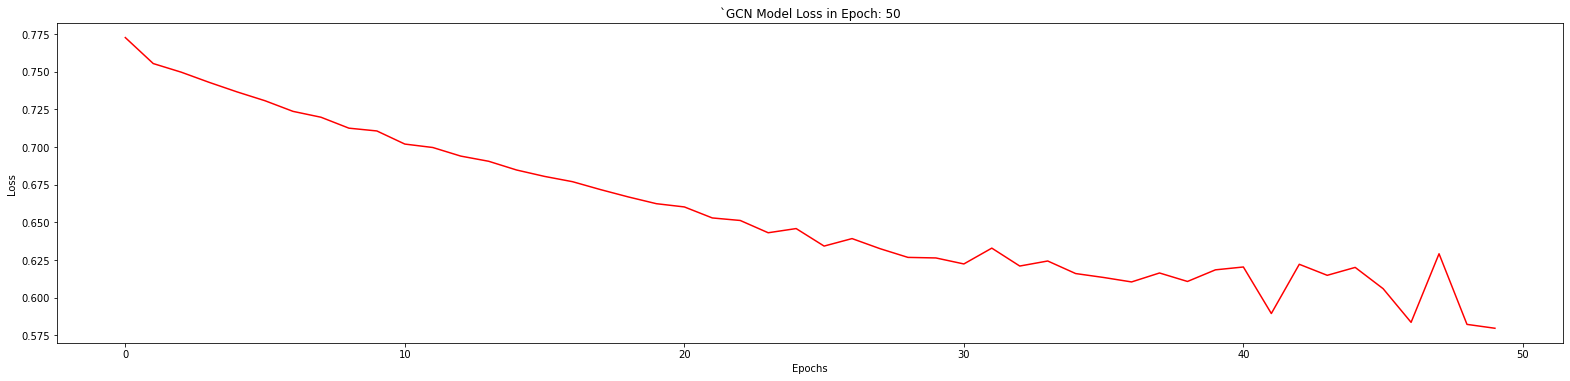

Epoch: 051, LRP Model Loss: 0.5784
Epoch: 052, LRP Model Loss: 0.6036
Epoch: 053, LRP Model Loss: 0.5968
Epoch: 054, LRP Model Loss: 0.6126
Epoch: 055, LRP Model Loss: 0.6179
Epoch: 056, LRP Model Loss: 0.6078
Epoch: 057, LRP Model Loss: 0.5942
Epoch: 058, LRP Model Loss: 0.5720
Epoch: 059, LRP Model Loss: 0.5897
Epoch: 060, LRP Model Loss: 0.5858
Epoch: 061, LRP Model Loss: 0.5805
Epoch: 062, LRP Model Loss: 0.5812
Epoch: 063, LRP Model Loss: 0.5722
Epoch: 064, LRP Model Loss: 0.5913
Epoch: 065, LRP Model Loss: 0.5789
Epoch: 066, LRP Model Loss: 0.5763
Epoch: 067, LRP Model Loss: 0.5897
Epoch: 068, LRP Model Loss: 0.5791
Epoch: 069, LRP Model Loss: 0.5608
Epoch: 070, LRP Model Loss: 0.5938
Epoch: 071, LRP Model Loss: 0.5803
Epoch: 072, LRP Model Loss: 0.5875
Epoch: 073, LRP Model Loss: 0.5856
Epoch: 074, LRP Model Loss: 0.5655
Epoch: 075, LRP Model Loss: 0.5850
Epoch: 076, LRP Model Loss: 0.5934
Epoch: 077, LRP Model Loss: 0.5674
Epoch: 078, LRP Model Loss: 0.5867
Epoch: 079, LRP Mode

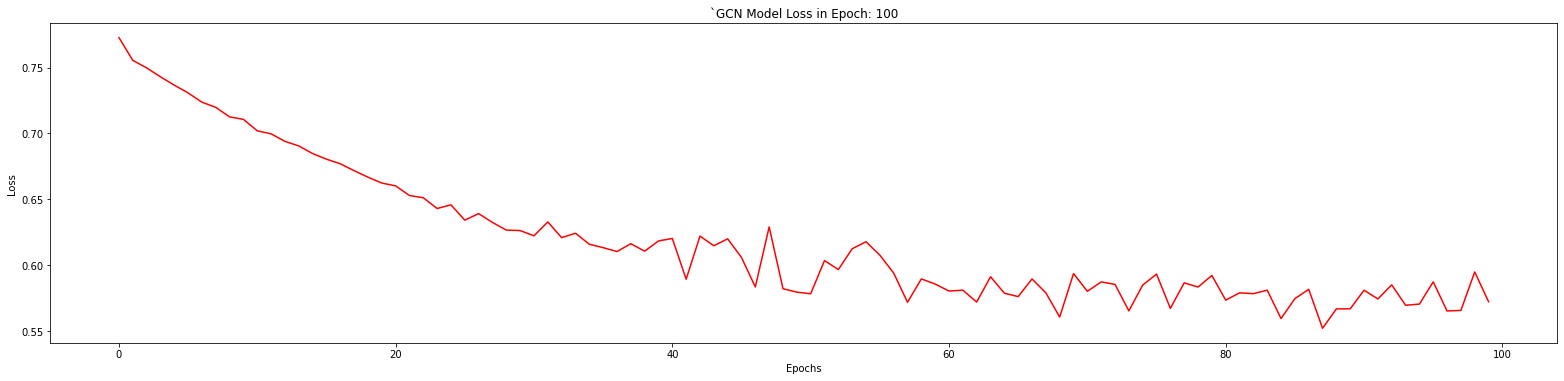

Epoch: 101, LRP Model Loss: 0.5554
Epoch: 102, LRP Model Loss: 0.5648
Epoch: 103, LRP Model Loss: 0.5596
Epoch: 104, LRP Model Loss: 0.5785
Epoch: 105, LRP Model Loss: 0.5712
Epoch: 106, LRP Model Loss: 0.5973
Epoch: 107, LRP Model Loss: 0.5781
Epoch: 108, LRP Model Loss: 0.5708
Epoch: 109, LRP Model Loss: 0.5277
Epoch: 110, LRP Model Loss: 0.5484
Epoch: 111, LRP Model Loss: 0.5452
Epoch: 112, LRP Model Loss: 0.5542
Epoch: 113, LRP Model Loss: 0.5719
Epoch: 114, LRP Model Loss: 0.5696
Epoch: 115, LRP Model Loss: 0.5654
Epoch: 116, LRP Model Loss: 0.5970
Epoch: 117, LRP Model Loss: 0.5574
Epoch: 118, LRP Model Loss: 0.5537
Epoch: 119, LRP Model Loss: 0.5608
Epoch: 120, LRP Model Loss: 0.5951
Epoch: 121, LRP Model Loss: 0.5549
Epoch: 122, LRP Model Loss: 0.5764
Epoch: 123, LRP Model Loss: 0.5765
Epoch: 124, LRP Model Loss: 0.5699
Epoch: 125, LRP Model Loss: 0.5432
Epoch: 126, LRP Model Loss: 0.5676
Epoch: 127, LRP Model Loss: 0.5538
Epoch: 128, LRP Model Loss: 0.5536
Epoch: 129, LRP Mode

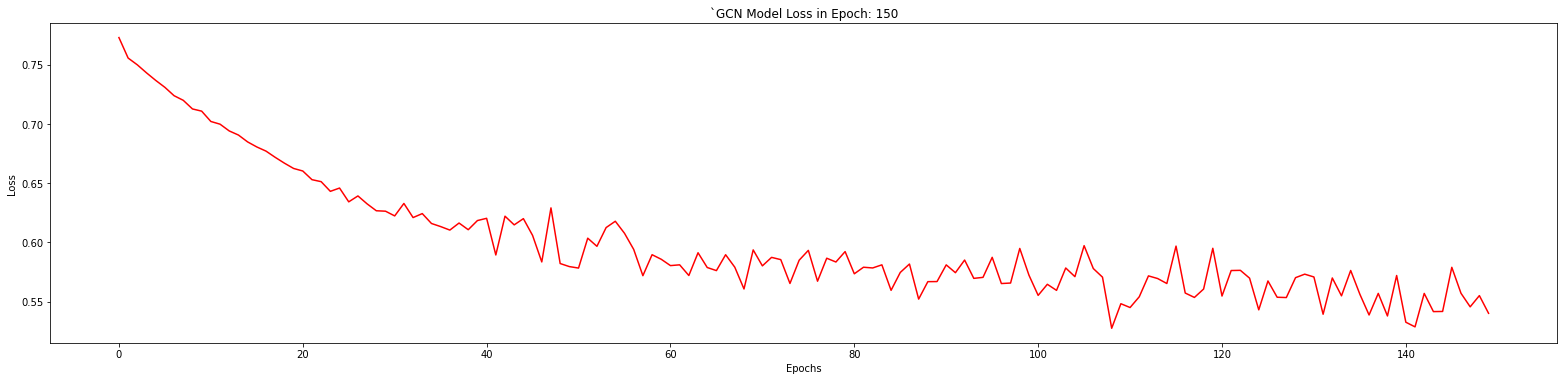

Epoch: 151, LRP Model Loss: 0.5371
Epoch: 152, LRP Model Loss: 0.5243
Epoch: 153, LRP Model Loss: 0.5476
Epoch: 154, LRP Model Loss: 0.5224
Epoch: 155, LRP Model Loss: 0.5533
Epoch: 156, LRP Model Loss: 0.5271
Epoch: 157, LRP Model Loss: 0.5349
Epoch: 158, LRP Model Loss: 0.5389
Epoch: 159, LRP Model Loss: 0.5359
Epoch: 160, LRP Model Loss: 0.5747
Epoch: 161, LRP Model Loss: 0.5564
Epoch: 162, LRP Model Loss: 0.5596
Epoch: 163, LRP Model Loss: 0.5503
Epoch: 164, LRP Model Loss: 0.5488
Epoch: 165, LRP Model Loss: 0.5202
Epoch: 166, LRP Model Loss: 0.5156
Epoch: 167, LRP Model Loss: 0.5546
Epoch: 168, LRP Model Loss: 0.5589
Epoch: 169, LRP Model Loss: 0.5551
Epoch: 170, LRP Model Loss: 0.5146
Epoch: 171, LRP Model Loss: 0.5430
Epoch: 172, LRP Model Loss: 0.5595
Epoch: 173, LRP Model Loss: 0.5241
Epoch: 174, LRP Model Loss: 0.5086
Epoch: 175, LRP Model Loss: 0.5116
Epoch: 176, LRP Model Loss: 0.5407
Epoch: 177, LRP Model Loss: 0.5298
Epoch: 178, LRP Model Loss: 0.5436
Epoch: 179, LRP Mode

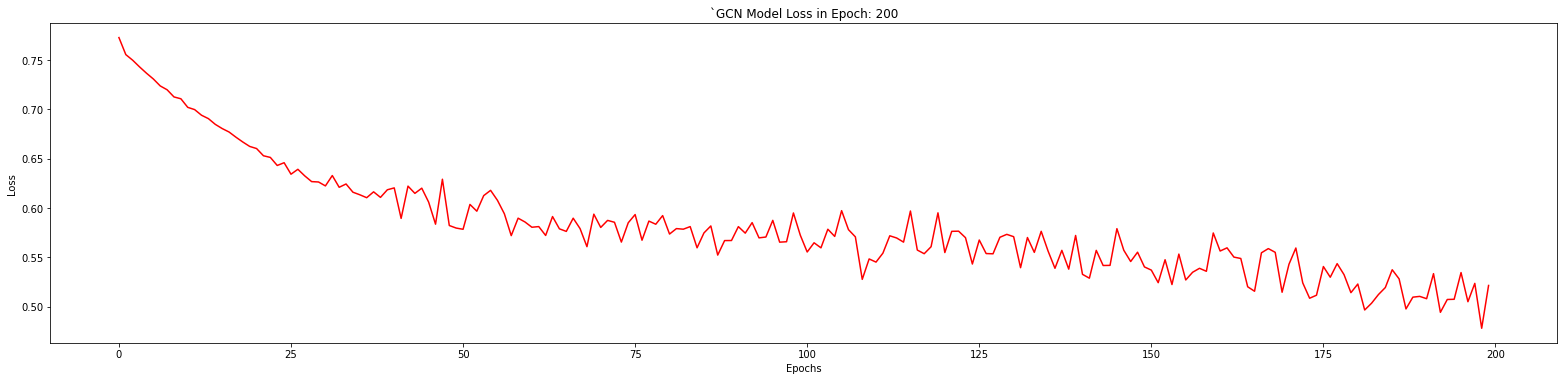

In [ ]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [ ]:
def GCN_Model_test(test_loader):
  predictions = []
  GCN_Model.eval()

  correct = 0
  for batch_of_graphs in test_loader:
    post_conv1_test, post_conv2_test, lrp_gap, GCN_Model_test_out  = GCN_Model(batch_of_graphs.x, batch_of_graphs.edge_index, batch_of_graphs.batch)
    GCN_Model_test_pred = GCN_Model_test_out.argmax(dim=1) 
    predictions.append(GCN_Model_test_pred) 

    correct += int((GCN_Model_test_pred == batch_of_graphs.y).sum())
      
  return correct / len(test_loader.dataset), predictions[0].detach().tolist() 

In [ ]:
GCN_Model_test_acc, predictions = GCN_Model_test(test_loader)
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.5526


In [ ]:
GCN_Model.eval()

post_conv1_test, post_conv2_test, lrp_gap, GCN_Model_test_out = GCN_Model(dataset[0].x, dataset[0].edge_index)


In [ ]:
print(predictions)
real_labels = []
for graph in test_dataset:
  real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print(Auc_Roc, Auc_Prc, Acc, Acc2)

0.48214285714285715 0.7642921960072595 0.5526315789473685 21


## **Instance Specific Time**

In [ ]:
def instance_time(test_dataset):
  instance_based_time = []
  GCN_Model.eval()
  correct = 0
  for batched_data in test_dataset:
    start_generation = perf_counter()
    post_conv1, post_conv2, out_readout, Grad_CAM_test_out = GCN_Model(batched_data.x, batched_data.edge_index, batched_data.batch)  
    CAM_test_pred = Grad_CAM_test_out.argmax(dim=1)
    consumed_time = perf_counter() - start_generation
    instance_based_time.append(consumed_time)    
  return instance_based_time

In [ ]:
times = instance_time(test_dataset)
print(f'Test Instance based Time: {times}')

Test Instance based Time: [0.0018312040000125762, 0.0012390830000015285, 0.0057092609999926935, 0.0014056899999843608, 0.0011823350000099708, 0.0011978280000164432, 0.0012683299999878273, 0.0031224579999786783, 0.0013339759999837497, 0.0011103999999875214, 0.0010379499999828568, 0.0009745679999753065, 0.0010126509999963673, 0.0010919400000091173, 0.000995361000008188, 0.0009546119999868097, 0.0009666299999935291, 0.0010618089999923086, 0.00094345700000531, 0.0009256609999965804, 0.0009519500000010339, 0.0009189950000063618, 0.0009252670000137186, 0.0009569480000095609, 0.0009834280000120543, 0.0010033390000216968, 0.0009694860000024619, 0.000995770000002949, 0.0009855629999719895, 0.0009454380000022411, 0.0009771009999894886, 0.0009443320000173117, 0.0009464919999970789, 0.001133321999986947, 0.001163442999995823, 0.0011393729999724655, 0.0009722480000107225, 0.0009918890000051306]


## **LayerWise Relevence Propagation**

In [ ]:
GCN_Model_state = GCN_Model.state_dict()
print(GCN_Model_state.keys())

odict_keys(['gconv1.weight', 'gconv1.lin.weight', 'gconv2.weight', 'gconv2.lin.weight', 'ffn.weight'])


In [ ]:
print(GCN_Model.gconv1.weight.detach().clone().shape)

torch.Size([7, 7])


In [ ]:
def GCN_Model_LRP(test_dataset):
  FFN_activations = []
  GConv2_activations = [] 
  GConv1_activations = [] 

  GCN_Model.eval()

  for batch_of_graphs in test_dataset:
    post_conv1_test_activations, post_conv2_test_activations, lrp_gap, GCN_Model_test_activations = GCN_Model(batch_of_graphs.x, batch_of_graphs.edge_index, batch_of_graphs.batch)
    GConv1_activations.append(post_conv1_test_activations.detach().tolist())
    GConv2_activations.append(post_conv2_test_activations.detach().tolist())
    FFN_activations.append(GCN_Model_test_activations.detach().tolist())  
    
  return GConv1_activations, GConv2_activations, FFN_activations 

In [ ]:

GConv1_activations, GConv2_activations, FFN_activations  = GCN_Model_LRP(test_dataset)
print(len(FFN_activations[0]))
#print(FFN_activations)
print(len(GConv1_activations[0]))
print(len(GConv2_activations[0]))
print(len(FFN_activations))

print(np.shape(GConv1_activations[0]))
print(np.shape(GConv2_activations[0]))
print(np.shape(FFN_activations))

1
17
17
38
(17, 7)
(17, 7)
(38, 1, 2)


In [ ]:
print(len(GConv1_activations))
print(len(GConv1_activations[0]))

38
17


In [ ]:
def accumulate_weights(model_for_you):

  #gconv1_bias = model_for_you.gconv1.bias.detach().tolist()
  gconv1_weight = model_for_you.gconv1.weight.detach().tolist()

  #gconv2_bias = model_for_you.gconv2.bias.detach().tolist()
  gconv2_weight = model_for_you.gconv2.weight.detach().tolist()

  #ffn_bias = model_for_you.ffn.bias.detach().tolist()
  ffn_weight = model_for_you.ffn.weight.detach().tolist()

  

  #return gconv1_weight, gconv1_bias, gconv2_weight, gconv2_bias, ffn_weight, ffn_bias
  return gconv1_weight, gconv2_weight, ffn_weight

In [ ]:
GConv1_weight, GConv2_weight, FFN_weight = accumulate_weights(GCN_Model)

In [ ]:
GConv1_weight_T = np.array(GConv1_weight).transpose()
GConv1_weight_T = GConv1_weight_T.tolist()
print(np.shape(GConv1_weight_T))

(7, 7)


In [ ]:
GConv2_weight_T = np.array(GConv2_weight).transpose()
GConv2_weight_T = GConv2_weight_T.tolist()
print(np.shape(GConv2_weight_T))

(7, 7)


In [ ]:
FFN_weight_T = np.array(FFN_weight).transpose()
FFN_weight_T = FFN_weight_T.tolist()
print(np.shape(FFN_weight_T))

(7, 2)


In [ ]:
GConv1_weight = GConv1_weight.copy()
GConv2_weight = GConv2_weight.copy()
FFN_weight = FFN_weight.copy()

In [ ]:
a = np.array([[1., 2.], [3., 4.], [5, 6]])
print(a)


b=a[::-1]
print(b)


[[1. 2.]
 [3. 4.]
 [5. 6.]]
[[5. 6.]
 [3. 4.]
 [1. 2.]]


In [ ]:
def my_relu(input):
  return np.maximum(0, input)
print(my_relu([0,1,2,3,4,-1,-2,-4,-6]))
print(my_relu(-1))

ls = [1,2,2,2,2,2,2]
z = [0] * len(ls)
print(z)

[0 1 2 3 4 0 0 0 0]
0
[0, 0, 0, 0, 0, 0, 0]


In [ ]:
def Compute_R_K(FFN_activations, wrt):
  #print(FFN_activations)
  FFN_activations = FFN_activations[0]
  if wrt == 2:  #.     Graph Label
    last_layer_R_k = [0] * len(FFN_activations)
    last_layer_R_k[FFN_activations.index(max(FFN_activations))] = FFN_activations[FFN_activations.index(max(FFN_activations))]
    #print(last_layer_R_k)
    return last_layer_R_k
  elif wrt == 0: #.    Class 0
    last_layer_R_k = [0] * len(FFN_activations)
    last_layer_R_k[0] = FFN_activations[0]
    #print(last_layer_R_k)
    return last_layer_R_k
  elif wrt == 1: #.    Class 1
    last_layer_R_k = [0] * len(FFN_activations)
    last_layer_R_k[1] = FFN_activations[1]
    #print(last_layer_R_k)
    return last_layer_R_k

In [ ]:
def Compute_R_J(epsilon, preceding_layer_activations, exceding_layer_weights, next_layer_R_k, is_it_last):
  Denominators = []
  for i in range(len(preceding_layer_activations)):
    SUM_Denominator = 0
    for j in range(len(preceding_layer_activations[i])):
      for k in range(len(exceding_layer_weights[j])):
        SUM_Denominator = SUM_Denominator + preceding_layer_activations[i][j] * my_relu(exceding_layer_weights[j][k])
      Denominators.append(epsilon + SUM_Denominator)
  #print("Denominator is done: ", Denominators)
  #print("Denominator Length: ", len(Denominators))
  
  if is_it_last:
    Numerators = []
    for i in range(len(preceding_layer_activations)):
      Node_Numerator = []
      for j in range(len(preceding_layer_activations[i])):
        SUM_Nominator = 0
        for k in range(len(exceding_layer_weights[j])):
          SUM_Nominator = SUM_Nominator + preceding_layer_activations[i][j] * my_relu(exceding_layer_weights[j][k]) * next_layer_R_k[k]
        Node_Numerator.append(SUM_Nominator)
      Numerators.append(Node_Numerator)
  else:
    Numerators = []
    for i in range(len(preceding_layer_activations)):
      Node_Numerator = []
      for j in range(len(preceding_layer_activations[i])):
        SUM_Nominator = 0
        for k in range(len(exceding_layer_weights[j])):
          SUM_Nominator = SUM_Nominator + preceding_layer_activations[i][j] * my_relu(exceding_layer_weights[j][k]) * next_layer_R_k[i][k]
        Node_Numerator.append(SUM_Nominator)
      Numerators.append(Node_Numerator)
  
  R_Js_Graph = []
  for i in range(len(Numerators)):
    R_Js_Graph.append([x / Denominators[i] for x in Node_Numerator])

  return R_Js_Graph

In [ ]:
def One_Graph_LRP(epsilon, wrt, graph_sample, weights, activations):
  GConv1_weight = weights[0]
  GConv1_weight_T = weights[1]

  GConv2_weight = weights[2]
  GConv2_weight_T = weights[3]

  FFN_weight = weights[4]
  FFN_weight_T = weights[5]

  GConv1_activations = activations[0]
  GConv2_activations = activations[1]
  FFN_activations = activations[2]

  last_layer_R_k = Compute_R_K(FFN_activations, wrt)
  #print("R_K: ",last_layer_R_k)
  R_J_hidden2 = Compute_R_J(epsilon, GConv2_activations, FFN_weight_T, last_layer_R_k, True)
  #print(R_J_hidden2)
  #print(len(R_J_hidden2))
  R_J_hidden1 = Compute_R_J(epsilon, GConv1_activations, GConv2_weight, R_J_hidden2, False)
  #print(R_J_hidden1)
  #print(len(R_J_hidden1))
  R_J_input = Compute_R_J(epsilon, graph_sample, GConv1_weight, R_J_hidden1, False)
  #print(R_J_input)
  #print(len(R_J_input))  
  
  
  return R_J_input

In [ ]:
print(np.shape(GConv1_weight), np.shape(GConv2_weight), np.shape(FFN_weight_T))
print(np.shape(GConv1_weight_T), np.shape(GConv2_weight_T), np.shape(FFN_weight))

(7, 7) (7, 7) (7, 2)
(7, 7) (7, 7) (2, 7)


In [ ]:
print(np.shape(dataset[0].x.detach().tolist()))

(17, 7)


In [ ]:
print(np.shape(dataset[0].x[0]), np.shape(GConv1_activations), np.shape(GConv2_activations), np.shape(FFN_activations))

torch.Size([7]) (38,) (38,) (38, 1, 2)


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
print(len(test_dataset[0].x))
print(test_dataset[0])

17
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [ ]:
Graph_Sample = 0
epsilon = 1e-16
wrt = 0
LRP = One_Graph_LRP(epsilon, wrt, test_dataset[Graph_Sample].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[Graph_Sample], GConv2_activations[Graph_Sample], FFN_activations[Graph_Sample]])

In [ ]:
print(LRP)

[[0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.12771118643283255, 0.0, 0.0, 0.0, 0.0]]


## **LRPs for all test graphs**

In [ ]:
LRPs_Testset = []
epsilon = 1e-16
wrt = 2
for i in range(len(test_dataset)):
  LRPs_Testset.append(One_Graph_LRP(epsilon, wrt, test_dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]]))

In [ ]:
print(np.shape(LRPs_Testset[0]))

(17, 7)


## **Normalize LRPs**

In [ ]:
def Normalize_LRPs(dataset,wrt):
  
  LRPs_Testset = []
  for i in range(len(dataset)):
    LRPs_Testset.append(One_Graph_LRP(epsilon, wrt, dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]]))
  Normalized_LRPs = []
  for i in range(len(LRPs_Testset)):
    Each_Graph = []
    for j in range(len(LRPs_Testset[i])):
      Each_Graph.append(sum(LRPs_Testset[i][j]))
    norm = [(float(i))/(max(Each_Graph) + 1e-16) for i in Each_Graph] 
    Normalized_LRPs.append(norm)
  return Normalized_LRPs

In [ ]:
norm_lrps = Normalize_LRPs(test_dataset, 1)

In [ ]:
print(norm_lrps)

[[1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016, 1.0000000000000016], [0.9999999999998859, 0.9999999999998859, 0.9999999999998859, 0.9999999999998859, 0.9999999999998859, 0.9999999999998859, 0.9999999999998859, 0.9999999999998859, 0.9999999999998859, 0.9999999999998859, 0.9999999999998859, 0.9999999999998859, 0.9999999999998859], [0.9999999999999185, 0.9999999999999185, 0.9999999999999185, 0.9999999999999185, 0.9999999999999185, 0.9999999999999185, 0.9999999999999185, 0.9999999999999185, 0.9999999999999185, 0.9999999999999185, 0.9999999999999185, 0.9999999999999185, 0.9999999999999185], [1.0000000000001703, 1.0000000000001703, 1.0000000000001703, 1.0000000000001703, 1.0000000000001703, 1.0000000000001703, 1.0000000000

## **Fiedelity**

In [ ]:
def Compute_ROC_AUC(your_model, your_dataset):
  preds = []
  reals = []
  #print(len(your_dataset))
  num_classes = 2
  
  if num_classes > 2:
    print("Fidelity is only for Binaryclassification")
    return 0
    
  your_model.eval()
  for batched_data in your_dataset:
    post_conv1, post_conv2, lrp_gap, out = your_model(batched_data.x, batched_data.edge_index, batched_data.batch)
    logits = F.log_softmax(out, dim=1)
    prob = F.softmax(logits, dim=1)
    
    preds.append(prob.cpu().detach())
    
  for i in range(len(your_dataset)):
    reals.append(your_dataset[i].y.cpu().detach().tolist())  
  preds = torch.cat(preds).cpu().numpy()
  preds = preds[:, 1]

  
  roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
  return roc_auc

In [ ]:
def is_salient(score, importance_range):
  start = importance_range[0]
  end = importance_range[1]
  #print(start, score, end)
  if float(start) <= float(score) <= float(end):
    return True
  else:
    return False

In [ ]:
def drop_important_nodes(your_dataset, importance_range, wrt):
  LRP_attribution_scores = Normalize_LRPs(test_dataset, wrt)
  occluded_GNNgraph_list = []
  
  for i in range(len(LRP_attribution_scores)):
    sample_graph = deepcopy(your_dataset[i])
    for j in range(len(sample_graph.x)):
      
      if is_salient((LRP_attribution_scores[i][j]), importance_range):
        #print("before: ", sample_graph.x[j])
        sample_graph.x[j][:] = 0
        #print(torch.zeros_like(sample_graph.x[j]))
        #print("manipulated: ",sample_graph.x[j])
    occluded_GNNgraph_list.append(sample_graph)
  return occluded_GNNgraph_list

In [ ]:
def Fidelity(your_model, your_dataset, importance_range):

  auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
  new_graph_dataset = drop_important_nodes(your_dataset, importance_range, wrt)
  auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

  return auc_roc_after_droping_important_nodes - auc_roc_before_droping_important_nodes

## **Contrastivity**

In [ ]:
def binarize_scores(dataset, wrt, importance_range):
  LRP_attribution_scores = Normalize_LRPs(dataset, wrt)
  binarized_attribution_scores_list = []
  for scores in LRP_attribution_scores:
    binary_score = ''
    for score in scores:
      if is_salient(abs(float(score)), importance_range):
        binary_score += '1'
      else:
        binary_score += '0'
    binarized_attribution_scores_list.append(binary_score)
  return binarized_attribution_scores_list

In [ ]:
def compute_contrastivity(dataset, importance_range):
  binarized_salient_nodes_for_class0 = binarize_scores(dataset, 0, importance_range)
  binarized_salient_nodes_for_class1 = binarize_scores(dataset, 1, importance_range)

  result_list = []
	# Calculate hamming distance
  for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
    assert len(class_0) == len(class_1)
    d = hamming(class_0, class_1)
    result_list.append(d / len(class_0))
    
  return sum(result_list) / len(result_list)

## **Sparsity**

In [ ]:
def binarize_nodes(dataset, importance_range):
  binarized_salient_nodes_for_graph = binarize_scores(dataset, 2, importance_range)
  binarized_salient_nodes_for_class0 = binarize_scores(dataset, 0, importance_range)
  binarized_salient_nodes_for_class1 = binarize_scores(dataset, 1, importance_range)

  class_0_salient_nodes = []
  class_1_salient_nodes = []
  salient_nodes_preds = []
  
  for i in range(len(binarized_salient_nodes_for_class0)):
      class_0_graph = []
      for j in range(len(binarized_salient_nodes_for_class0[i])):
        if is_salient((binarized_salient_nodes_for_class0[i][j]), importance_range):
          class_0_graph.append(1)
        else:
          class_0_graph.append(0)
      class_0_salient_nodes.append(class_0_graph)

  for i in range(len(binarized_salient_nodes_for_class1)):
      class_1_graph = []
      for j in range(len(binarized_salient_nodes_for_class1[i])):
        if is_salient((binarized_salient_nodes_for_class1[i][j]), importance_range):
          class_1_graph.append(1)
        else:
          class_1_graph.append(0)
      class_1_salient_nodes.append(class_1_graph)

  for i in range(len(binarized_salient_nodes_for_graph)):
      class_graph = []
      for j in range(len(binarized_salient_nodes_for_graph[i])):
        if is_salient((binarized_salient_nodes_for_graph[i][j]), importance_range):
          class_graph.append(1)
        else:
          class_graph.append(0)
      salient_nodes_preds.append(class_graph)

  return salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes

In [ ]:
def count_important_nodes(salient_list):
  return sum(salient_list)

In [ ]:
def compute_sparsity(dataset, importance_range):
  salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(dataset, importance_range)
  #print(salient_nodes_graph)
  #print(class_0_salient_nodes)
  #print(class_1_salient_nodes)
  sparsity_list = []
  for i in range(len(salient_nodes_preds)):
    d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
    d = d / (len(salient_nodes_preds) * 2)
    sparsity_list.append(1 - d)
  return sum(sparsity_list) / len(sparsity_list)

In [ ]:
def go_to_evaluations(your_model, dataset, importance_range):
  start_generation = perf_counter()
  norm_lrps = Normalize_LRPs(dataset, 2)
  time_consumption = perf_counter() - start_generation

  fid_LRP_label = Fidelity(your_model, dataset, importance_range)

  contrastivity_with_LRP = compute_contrastivity(dataset, importance_range)

  sparsity_with_LRP = compute_sparsity(dataset, importance_range)


  #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
  #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
  #  wr = csv.writer(outcsv, dialect='excel', delimiter=',')
  #  wr.writerow([str(Explainability_name), "MUTAG", fid_LRP_label, contrastivity_with_LRP, sparsity_with_LRP, time_consumption])
  task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
  with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods for SoftWare.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, LRP_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_LRP_label, contrastivity_with_LRP, sparsity_with_LRP, time_consumption, mean(LRP_Model_training_time_per_epoch), times])


  #return fid_LRP_label, contrastivity_with_LRP, sparsity_with_LRP, time_consumption

## **Get Metrics**

In [ ]:
#fid_LRP_label, contrastivity_with_LRP, sparsity_with_LRP, time_consumption = go_to_evaluations(GCN_Model, test_dataset, [0.5, 1])
#print(fid_LRP_label, contrastivity_with_LRP, sparsity_with_LRP, time_consumption)
go_to_evaluations(GCN_Model, test_dataset, [0.5, 1])

In [ ]:
def LRP_Relevance_Graph_Features(LRP, sample):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("LRP generated for sample Graph: " + str(sample) + "where the GNN is trained on " + str(EPOCHS) + " Epochs")
  
  ax1.plot(LRP, color='r')
  print('done')
  
  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "LRP generated for sample number: " + str(sample) + ".png")
  plt.show()

(7,)
done


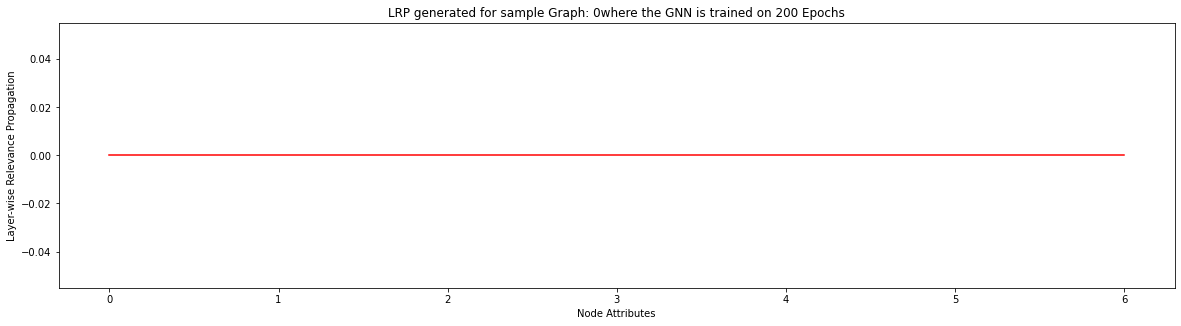

In [ ]:
Averaged_LRP = np.mean(LRP, axis=0)
print(np.shape(Averaged_LRP))
LRP_Relevance_Graph_Features(Averaged_LRP, 0)

## **Relevances of Graphs in each Class**

In [ ]:
Graph_Index_Class1 = []
Graph_Index_Class2 = []

In [ ]:
for i in range(len(test_dataset)):
  if test_dataset[i].y == 0:
    Graph_Index_Class1.append(i)
  else:
    Graph_Index_Class2.append(i)

In [ ]:
print(len(Graph_Index_Class1), len(Graph_Index_Class2))
print(Graph_Index_Class1)
print(Graph_Index_Class2)

24 33
[4, 5, 6, 7, 12, 16, 21, 25, 26, 28, 29, 30, 31, 33, 36, 37, 39, 42, 50, 52, 53, 54, 55, 56]
[0, 1, 2, 3, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 27, 32, 34, 35, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51]


In [ ]:
LRPs_Class1 = []
LRPs_Class2 = []

## **LRP of Graphs in each Class**

In [ ]:
for index in Graph_Index_Class1:
  LRPs_Class1.append(LRPs_Testset[index])
for index in Graph_Index_Class2:
  LRPs_Class2.append(LRPs_Testset[index])

In [ ]:
print(len(LRPs_Class1[1]))
print(len(LRPs_Class2))


11
33


## **Averaged Relevances on Node Features in all Graphs**

In [ ]:
LRPs_Class1_Averaged_on_Nodes = []
LRPs_Class2_Averaged_on_Nodes = []
for graph in LRPs_Class1:
  LRPs_Class1_Averaged_on_Nodes.append(np.mean(graph, axis=0))

for graph in LRPs_Class2:
  LRPs_Class2_Averaged_on_Nodes.append(np.mean(graph, axis=0))

In [ ]:
print(len(LRPs_Class1_Averaged_on_Nodes))
print(len(LRPs_Class2_Averaged_on_Nodes))

24
33


## **Averaged Relevances on Graphs in each Class**

In [ ]:
LRPs_Class1_Averaged_on_Graphs = []
LRPs_Class2_Averaged_on_Graphs = []
LRPs_Class1_Averaged_on_Graphs = np.mean(LRPs_Class1_Averaged_on_Nodes, axis=0)
LRPs_Class2_Averaged_on_Graphs = np.mean(LRPs_Class2_Averaged_on_Nodes, axis=0)

## **PLOT Average Relevances**

In [ ]:
def Averaged_LRP_Relevance_Classes(LRP):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Avg Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: One, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax2 = plt.subplot2grid((7, 1), (1, 0), colspan=7)
  plt.xlabel("Avg Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: Two, where the GNN is trained on " + str(EPOCHS) + " Epochs") 

  ax1.plot(LRP[0], color='r')
  ax2.plot(LRP[1], color='r') 

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Dimensionally Averaged LRPs for Classes.png")
  plt.show()

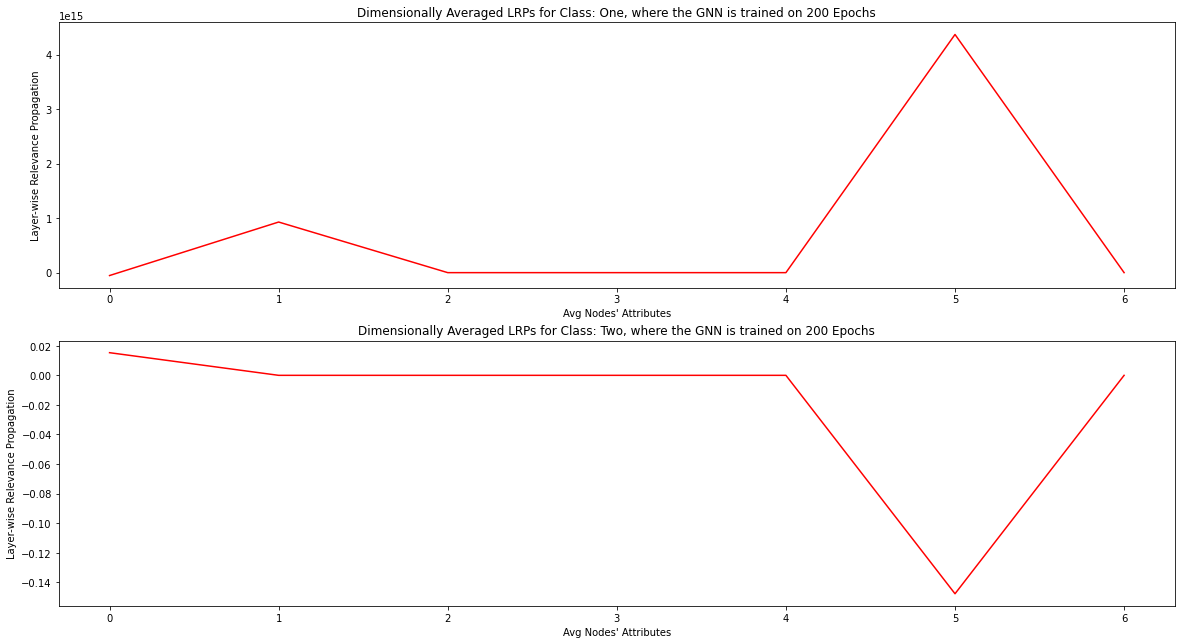

In [ ]:
Averaged_LRP_Relevance_Classes([LRPs_Class1_Averaged_on_Graphs, LRPs_Class2_Averaged_on_Graphs])